### This notebook is a babystep of figuring out how to use AutoML tables for benchmark purpose. The notebook followed the steps and helper function defined in this tutorial **https://www.kaggle.com/philculliton/automlwrapper**

In [ ]:
# library
import matplotlib.pyplot as plt
from palettable.colorbrewer.qualitative import Pastel1_7
import numpy as np 
import pandas as pd 
import time
from datetime import datetime

from sklearn.model_selection import train_test_split
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
#google cloud connection        
from google.cloud import storage
from google.cloud import automl_v1beta1 as automl

# workaround to fix gapic_v1 error
from google.api_core.gapic_v1.client_info import ClientInfo


In [ ]:
sample_submission = pd.read_csv("../input/tabular-playground-series-may-2021/sample_submission.csv")
test_df = pd.read_csv("../input/tabular-playground-series-may-2021/test.csv")
train_df = pd.read_csv("../input/tabular-playground-series-may-2021/train.csv")

In [ ]:
#examine the distribution of the class in train#
 

names = ['Class_1', 'Class_2', 'Class_3', 'Class_4']
size = train_df.target.value_counts()
 
my_circle = plt.Circle( (0,0), 0.7, color='white')

from palettable.colorbrewer.qualitative import Pastel1_7
plt.pie(size, labels=names, colors=Pastel1_7.hex_colors)
p = plt.gcf()
p.gca().add_artist(my_circle)

# Show the graph
plt.show()

In [ ]:
#examine the missing values

#uncomment to run the profiling - it takes quite some time to run(5 minutes at least)#
from pandas_profiling import ProfileReport
#profile = ProfileReport(train_df, title="Profiling Report")
#profile.to_file("report.html")
#profile

#### To set up the google cloud project - hover to the google cloud platform. You need to specify an unique project_id so that you can get started. Afterwards, go to the "bucket" page and click create a bucket with universal unique bucket_name. Do not use the name in the next cell directly.
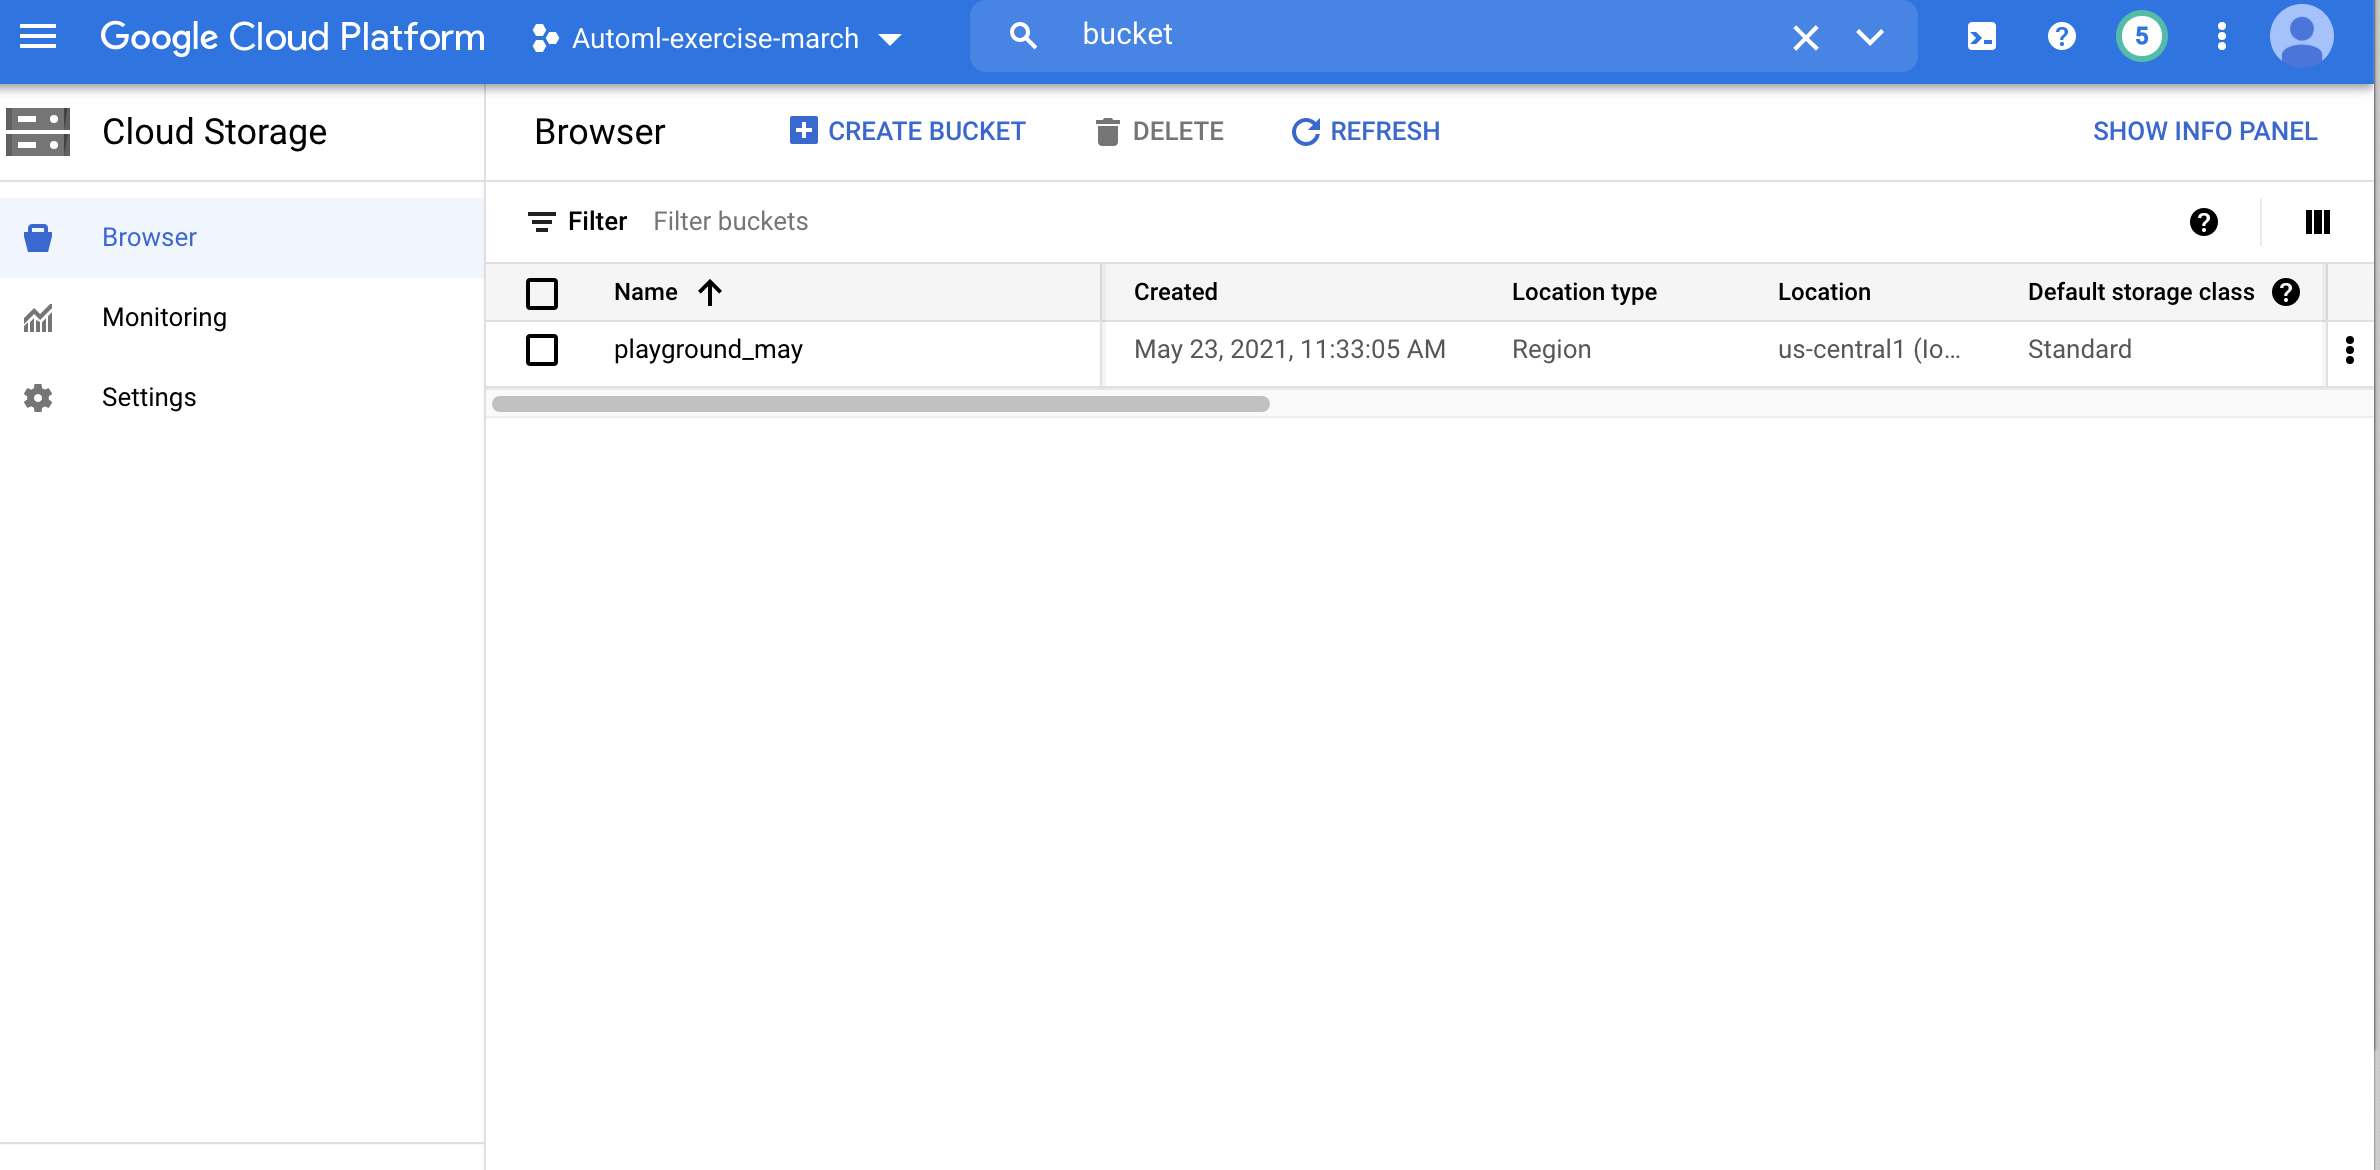

Noted that the bucket needs to be set to 'us-central1' as the Automl Table currently supports us-central1

In [ ]:
#Change the following for your project and bucket name
PROJECT_ID = 'automl-exercise-march'
BUCKET_NAME = 'playground_may'
#Note: the bucket_region must be us-central1.
BUCKET_REGION = 'us-central1'

In [ ]:
from google.cloud import storage, automl_v1beta1 as automl

storage_client = storage.Client(project=PROJECT_ID)
tables_gcs_client = automl.GcsClient(client=storage_client, bucket_name=BUCKET_NAME)
automl_client = automl.AutoMlClient()
# Note: AutoML Tables currently is only eligible for region us-central1. 
prediction_client = automl.PredictionServiceClient()
# Note: This line runs unsuccessfully without each one of these parameters
tables_client = automl.TablesClient(project=PROJECT_ID, region=BUCKET_REGION, client=automl_client, gcs_client=tables_gcs_client, prediction_client=prediction_client)

In [ ]:
# Create your GCS Bucket with your specified name and region (if it doesn't already exist)
bucket = storage.Bucket(storage_client, name=BUCKET_NAME)
if not bucket.exists():
    bucket.create(location=BUCKET_REGION)

In [ ]:
###these are awesome helper functions created in the above mentioned notebook. You can use it to upload the file if you don't want to hover to the GCP and upload there.

def upload_blob(bucket_name, source_file_name, destination_blob_name):
    """Uploads a file to the bucket. https://cloud.google.com/storage/docs/ """
    bucket = storage_client.get_bucket(bucket_name)
    blob = bucket.blob(destination_blob_name)
    blob.upload_from_filename(source_file_name)
    print('File {} uploaded to {}.'.format(
        source_file_name,
        destination_blob_name))
    
def download_to_kaggle(bucket_name,destination_directory,file_name,prefix=None):
    """Takes the data from your GCS Bucket and puts it into the working directory of your Kaggle notebook"""
    os.makedirs(destination_directory, exist_ok = True)
    full_file_path = os.path.join(destination_directory, file_name)
    blobs = storage_client.list_blobs(bucket_name,prefix=prefix)
    for blob in blobs:
        blob.download_to_filename(full_file_path)

In [ ]:
train_df.to_csv(path_or_buf='train.csv', index=False)
test_df.to_csv(path_or_buf='test.csv', index=False)

In [ ]:
###upload the train,test files into the bucket that you created earlier
upload_blob(BUCKET_NAME, 'train.csv', 'train.csv')
upload_blob(BUCKET_NAME, 'test.csv', 'test.csv')

#### One can direct create the dataset on GCP and point the data source. (It can be files in your bucket, local, or bigquery)


In [ ]:
###can create the dataset directly on GCP or create it using this snippet.
dataset_display_name = 'playground_may'
new_dataset = False
try:
    dataset = tables_client.get_dataset(dataset_display_name=dataset_display_name)
except:
    new_dataset = True
    dataset = tables_client.create_dataset(dataset_display_name)

In [ ]:
# gcs_input_uris have the familiar path of gs://BUCKETNAME//file

if new_dataset:
    gcs_input_uris = ['gs://' + BUCKET_NAME + '/train.csv']

    import_data_operation = tables_client.import_data(
        dataset=dataset,
        gcs_input_uris=gcs_input_uris
    )
    print('Dataset import operation: {}'.format(import_data_operation))

    # Synchronous check of operation status. Wait until import is done.
    import_data_operation.result()
    print(dataset)

In [ ]:
model_display_name = 'playground_may'
TARGET_COLUMN = 'target'
ID_COLUMN = 'id'

# TODO: File bug: if you run this right after the last step, when data import isn't complete, you get a list index out of range
# There might be a more general issue, if you provide invalid display names, etc.

tables_client.set_target_column(
    dataset=dataset,
    column_spec_display_name=TARGET_COLUMN
)

In [ ]:
#set the training budget and create a model
TRAIN_BUDGET = 7000
model = None
try:
    model = tables_client.get_model(model_display_name=model_display_name)
except:
    response = tables_client.create_model(
        model_display_name,
        dataset=dataset,
        train_budget_milli_node_hours=TRAIN_BUDGET,
        exclude_column_spec_names=[ID_COLUMN, TARGET_COLUMN]
    )
    print('Create model operation: {}'.format(response.operation))
    # Wait until model training is done.
    model = response.result()
# print(model)

#### After training you can directly get the feature importance and the evaluation graph in the evaluation tab
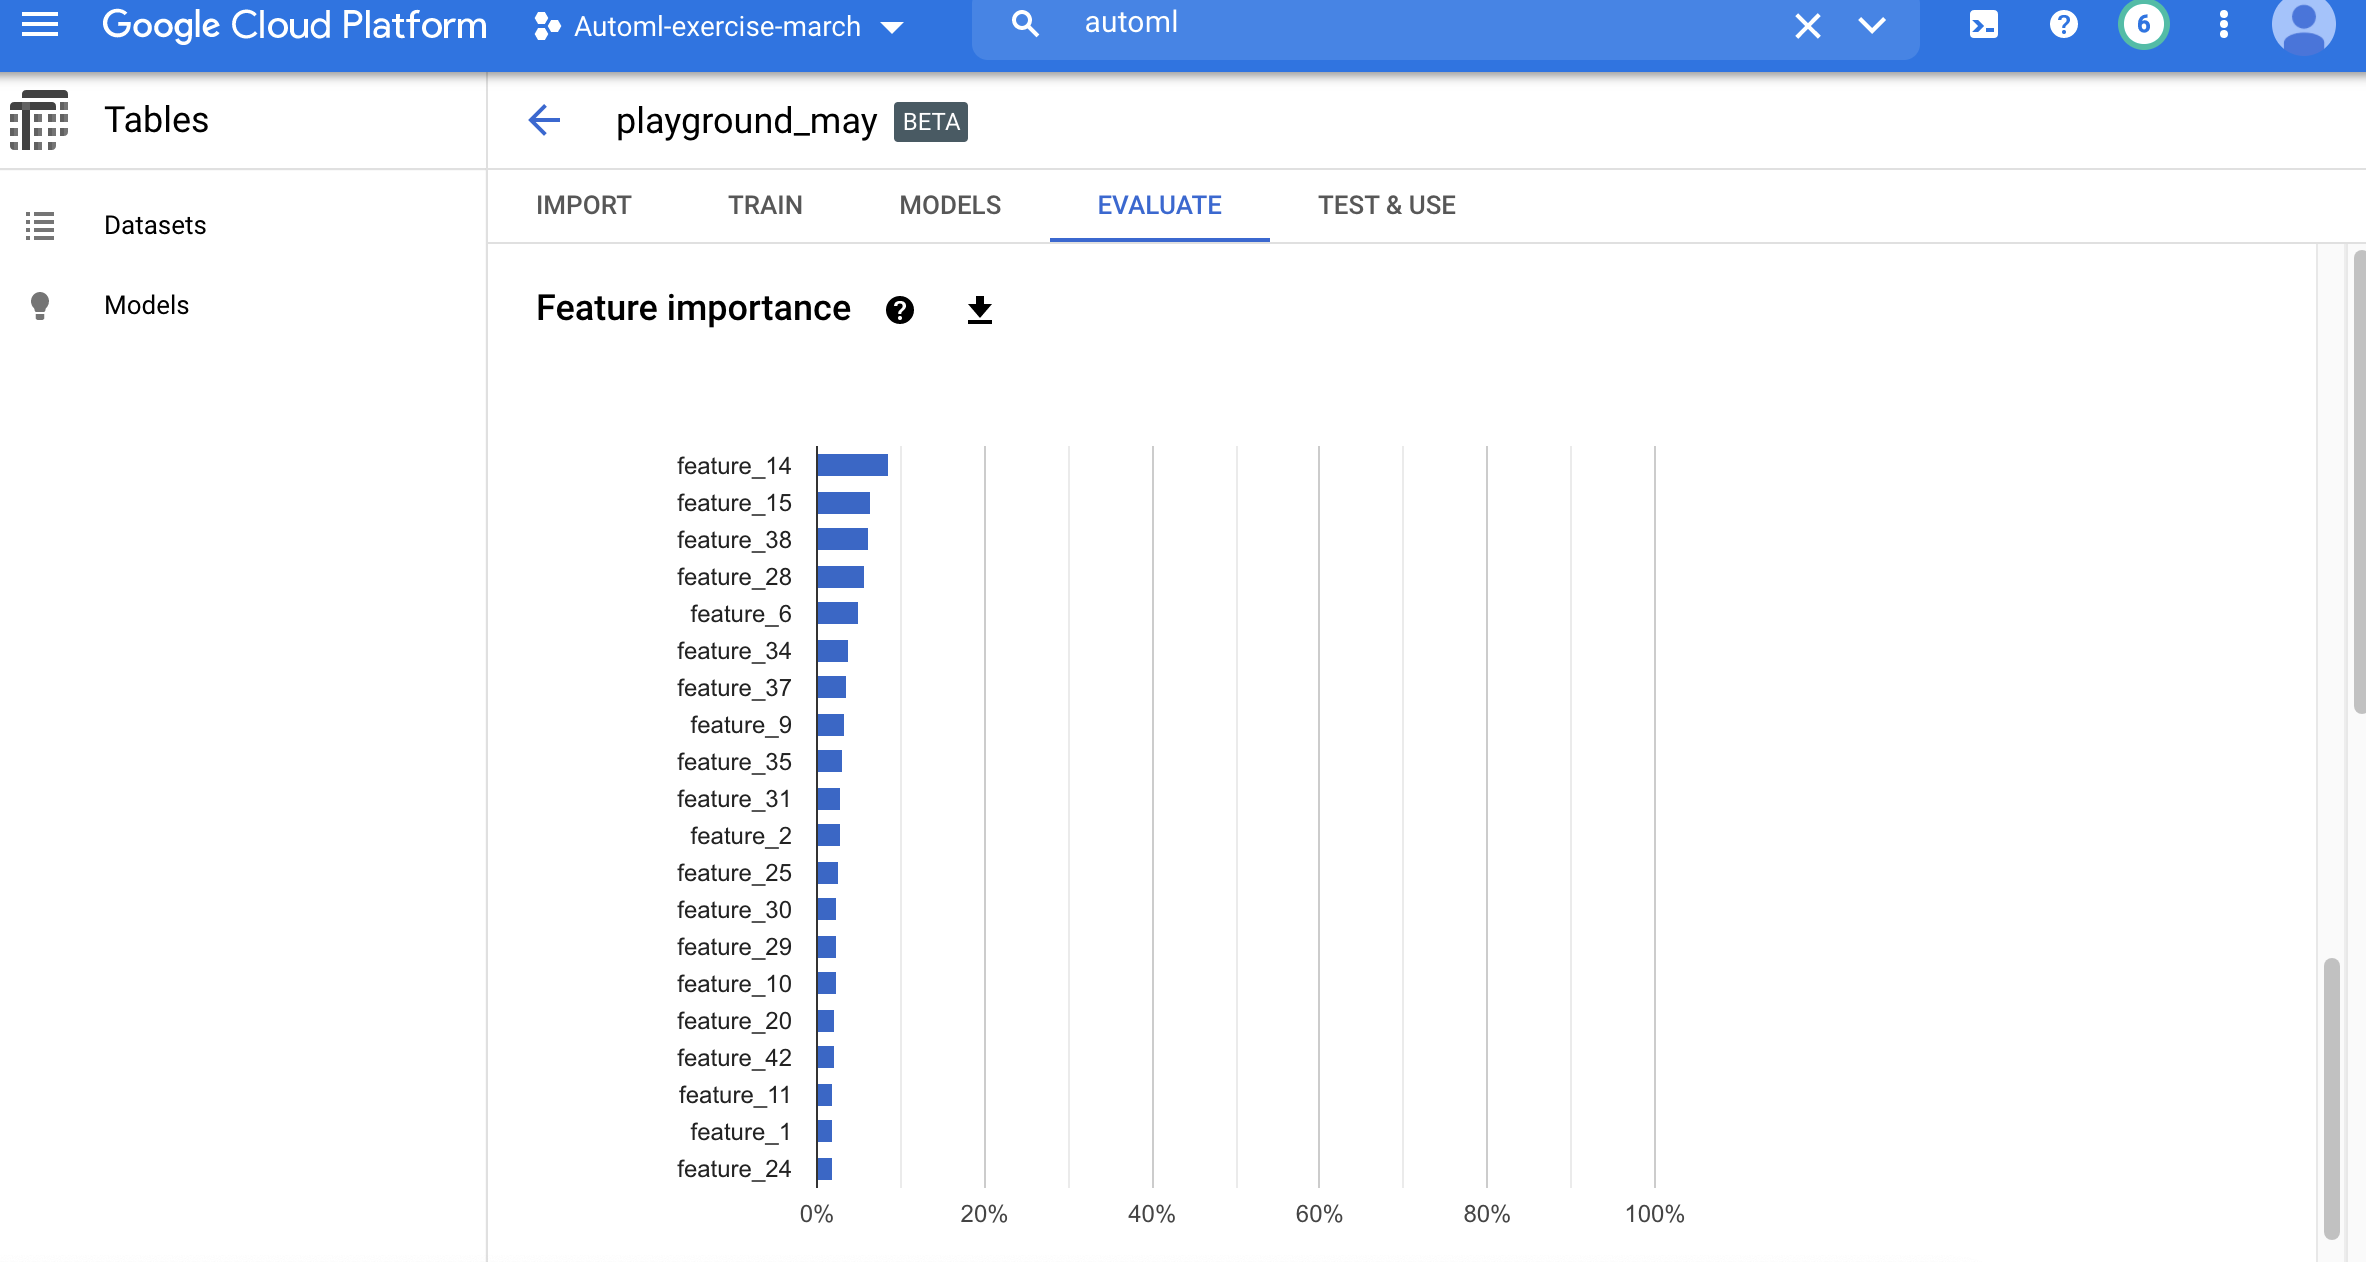

In [ ]:
gcs_input_uris = 'gs://' + BUCKET_NAME + '/test.csv'
gcs_output_uri_prefix = 'gs://' + BUCKET_NAME + '/predictions'

batch_predict_response = tables_client.batch_predict(
    model=model, 
    gcs_input_uris=gcs_input_uris,
    gcs_output_uri_prefix=gcs_output_uri_prefix,
)
print('Batch prediction operation: {}'.format(batch_predict_response.operation))
# Wait until batch prediction is done.
batch_predict_result = batch_predict_response.result()
batch_predict_response.metadata

#### The following cells serves as a purpose for easier retriving the table_1.csv by providing the path. One can hover to the GCP to see how exactly the path looks like.

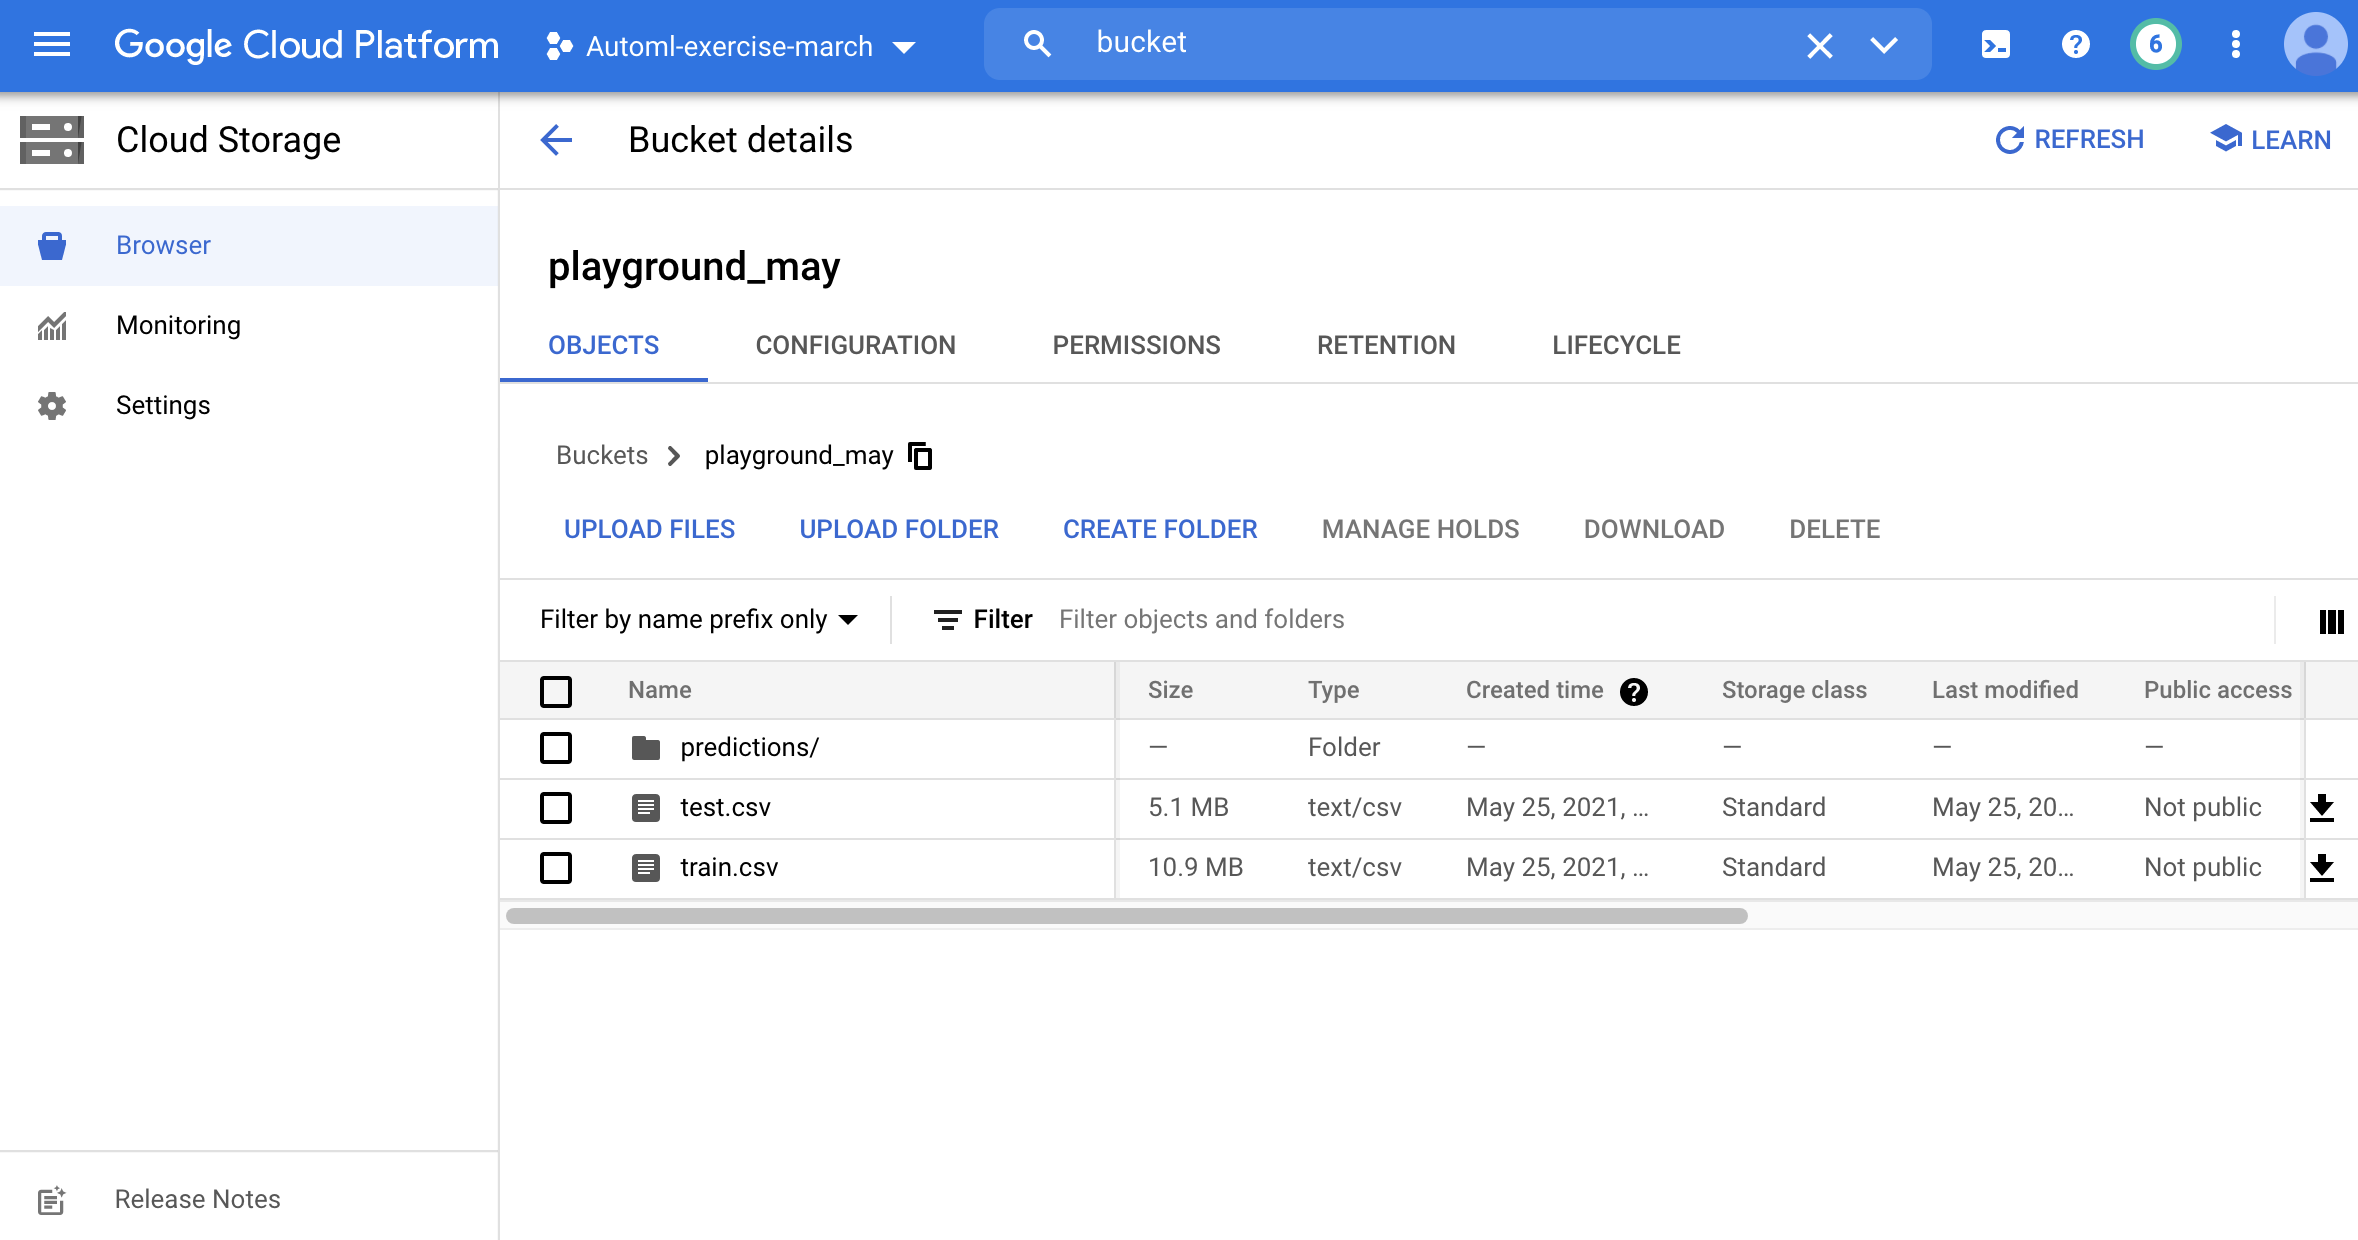

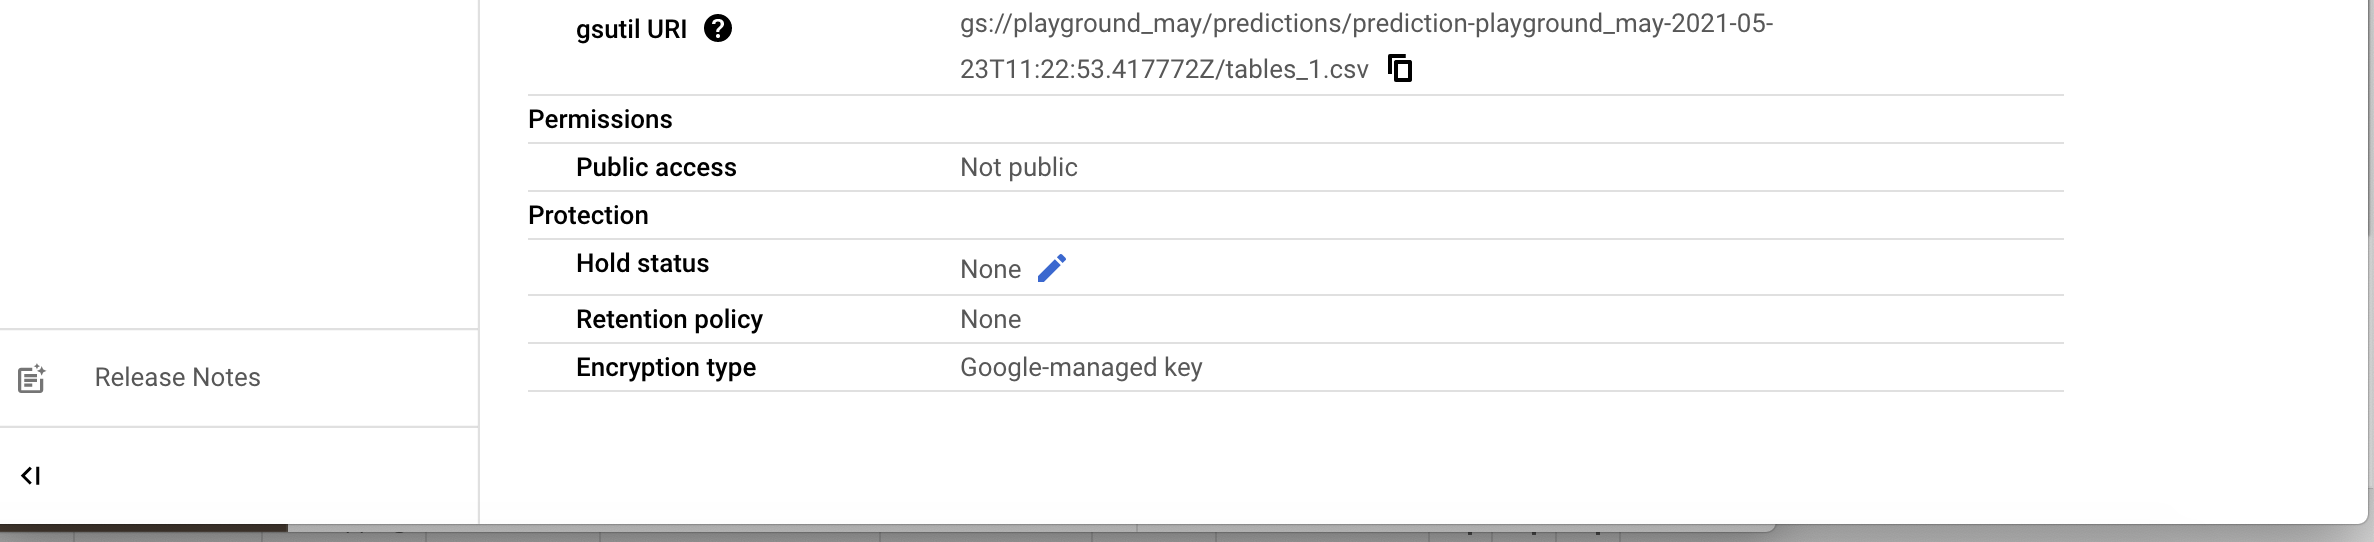

In [ ]:
# The output directory for the prediction results exists under the response metadata for the batch_predict operation
# Specifically, under metadata --> batch_predict_details --> output_info --> gcs_output_directory
#this step is neede for later to feed the path for retreiving the tables_1.csv
gcs_output_folder = batch_predict_response.metadata.batch_predict_details.output_info.gcs_output_directory.replace('gs://' + BUCKET_NAME + '/','')


In [ ]:
download_to_kaggle(BUCKET_NAME,'/kaggle/working','tables_1.csv', prefix=gcs_output_folder)

In [ ]:
prediction = pd.read_csv("tables_1.csv")

In [ ]:
submission = prediction[['id', 'target_Class_1_score','target_Class_2_score','target_Class_3_score','target_Class_4_score']]
submission.head()

In [ ]:
submission = submission.rename(columns={"target_Class_1_score": "Class_1", "target_Class_2_score": "Class_2","target_Class_3_score": "Class_3","target_Class_4_score": "Class_4"})

In [ ]:
submission = submission.sort_values(by=['id'])
submission.head()

In [ ]:
submission.to_csv('submission.csv', index=False)